In [1]:
import torch,math
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchview import draw_graph
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F

In [2]:
transformer = transforms.Compose([
    transforms.RandomCrop(32, padding=4,padding_mode='reflect'), #hyperparameter 1
    transforms.RandomHorizontalFlip(p=0.3), #hyperparameter 4
    transforms.ToTensor(), #torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) #hyperparameter 5
])

In [3]:
dataset = torchvision.datasets.CIFAR10(root='data/', transform = transformer, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='data/',transform = transformer,download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 64  #hyperparameter 2
dataset_size = len(dataset)
train_size = int(0.8*dataset_size) #hyperparameter 3
val_size = int(0.2*dataset_size)

In [5]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dl = DataLoader(train_dataset,batch_size,shuffle=True)
val_dl = DataLoader(val_dataset,batch_size,shuffle=True)
test_dl = DataLoader(test_dataset,batch_size)

In [6]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


In [7]:
def get_default_devices():
  return torch.device("cuda").type if torch.cuda.is_available() else torch.device("cpu")

def to_device(data,device):
  if(isinstance(data,(list,tuple))):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)
  #non blocking means you dont want to block execution of code when transferring code

class DeviceDataLoader():
  ''' wrapper around dataloaders to transfer batches to specified devices'''
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)
  def __len__(self):
    return len(self.dl)

device = get_default_devices()
train_dl = DeviceDataLoader(train_dl,device)
test_dl = DeviceDataLoader(test_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

In [8]:
device

'cuda'

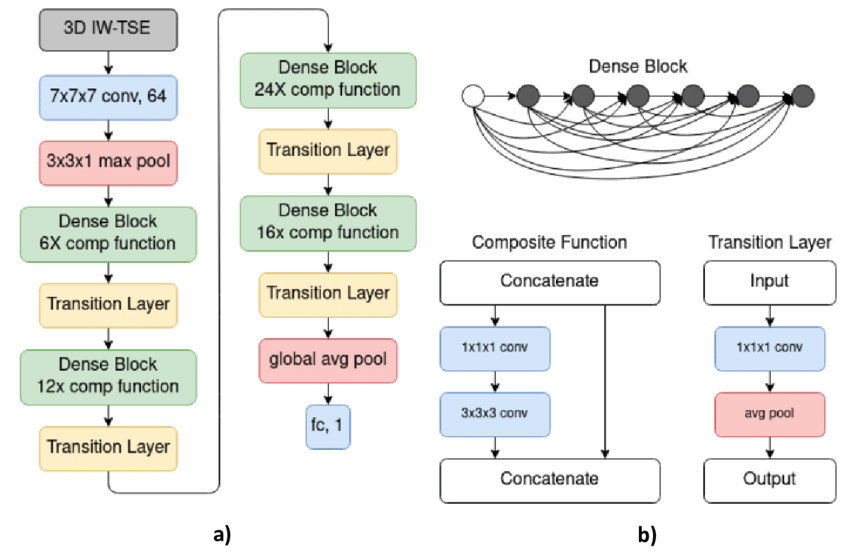

In [9]:
class Transition(nn.Module):
    def __init__(self, n_channels, n_out_channels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.conv1 = nn.Conv2d(n_channels, n_out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out

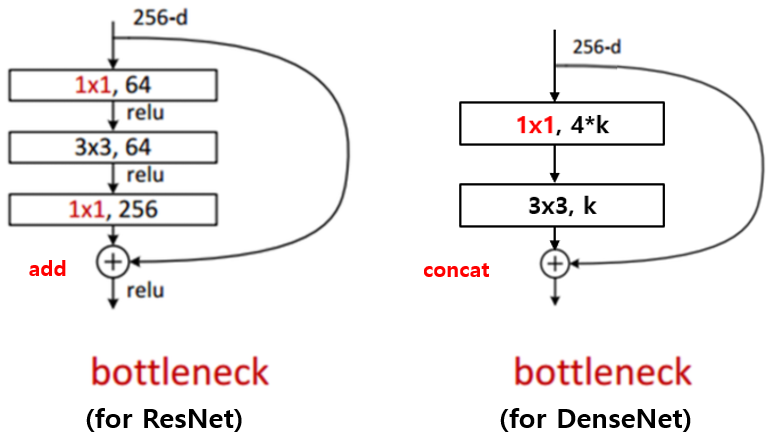

In [10]:
class Bottleneck(nn.Module):
    def __init__(self, n_channels, growth_rate):
        super(Bottleneck, self).__init__()
        inter_channels = 4 * growth_rate
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.conv1 = nn.Conv2d(n_channels, inter_channels, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_channels)
        self.conv2 = nn.Conv2d(inter_channels, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        return out

In [11]:
class SingleLayer(nn.Module):
    def __init__(self, input_channels, growth_rate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.conv1 = nn.Conv2d(input_channels, growth_rate, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        return out

In [12]:
class DenseNet(nn.Module):
    def __init__(self, growth_rate, depth, reduction, n_classes, bottleneck, infection, n_channels):
        super(DenseNet, self).__init__()
        
        self.infection = infection
        n_dense_blocks = (depth - 4) // 3
        if bottleneck:
            n_dense_blocks //= 2
        
        self.conv1 = nn.Conv2d(3, n_channels, kernel_size=3, padding=1, bias=True)
        
        self.dense1 = self._make_dense(n_channels, growth_rate, n_dense_blocks, bottleneck)
        n_channels = self.predict_dense_block_output(n_channels,growth_rate,n_dense_blocks)

        self.trans1 = self._make_transition(n_channels, int(n_channels * reduction))
        n_channels = int(n_channels * reduction)
        
        self.dense2 = self._make_dense(n_channels, growth_rate, n_dense_blocks, bottleneck)
        n_channels = self.predict_dense_block_output(n_channels,growth_rate,n_dense_blocks)

        self.trans2 = self._make_transition(n_channels, int(n_channels * reduction))
        n_channels = int(n_channels * reduction)

        # Third dense block
        self.dense3 = self._make_dense(n_channels, growth_rate, n_dense_blocks, bottleneck)
        n_channels = self.predict_dense_block_output(n_channels,growth_rate,n_dense_blocks)

        # Batch normalization and fully connected layer
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.fc = nn.Linear(n_channels, n_classes)
        
        self._initialize_weights()
        
    def predict_dense_block_output(self, n_channels, growth_rate, n_dense_blocks):
        if n_dense_blocks <= self.infection:
            output_channels = n_channels + n_dense_blocks * growth_rate
        else:
            output_channels = self.infection * growth_rate
        return output_channels
    
    def predict_input_channels(self, i, n_channels, growth_rate):
        if i <= self.infection:
            input_channels = n_channels + i * growth_rate
        else:
            input_channels = self.infection * growth_rate
        return input_channels

    def _make_dense(self, n_channels, growth_rate, n_dense_blocks, bottleneck):
        layers = []
        for i in range(n_dense_blocks):
            input_channels = self.predict_input_channels(i, n_channels, growth_rate)
            if bottleneck:
                layers.append(Bottleneck(input_channels, growth_rate))
            else:
                layers.append(SingleLayer(input_channels, growth_rate))
        return nn.ModuleList(layers)

    def _make_transition(self, in_channels, out_channels):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.conv1(x)

        # First dense block and transition
        out = self._process_dense_block(self.dense1, out)
        out = self.trans1(out)

        # Second dense block and transition
        out = self._process_dense_block(self.dense2, out)
        out = self.trans2(out)

        # Third dense block
        out = self._process_dense_block(self.dense3, out)

        out = F.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def _process_dense_block(self, dense_block, x):
        layer_outputs = [x]  
        out = x
        
        for i, layer in enumerate(dense_block):
            if i <= self.infection:
                previous_outputs = layer_outputs
            else:
                previous_outputs = layer_outputs[-self.infection:]
    
            out = torch.cat(previous_outputs, dim=1)
            out = layer(out)
            layer_outputs.append(out)
        
        return torch.cat(layer_outputs[-self.infection:],dim=1)


7 is the minimum network length

In [39]:
model = DenseNet(growth_rate=12, depth=121, reduction=0.3, n_classes=10, bottleneck=True,infection=39,n_channels=3)
to_device(model,device)

DenseNet(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense1): ModuleList(
    (0): Bottleneck(
      (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(3, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(15, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1)

In [32]:
depth = 121
(depth - 4)//3 

39

In [40]:
from calflops import calculate_flops
flops, macs, params = calculate_flops(model, input_shape=(1, 3, 32, 32), output_as_string=True, output_precision=4)
print(f"FLOPS: {flops}   MACs: {macs}   Params: {params}")


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  809.04 K
fwd MACs:                                                               312.038 MMACs
fwd FLOPs:                                                              638.336 MFLOPS
fwd+bwd MACs:                                                           936.113 MMACs
fwd+bwd FLOPs:                                                          1.915 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each modu

In [38]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()  # Total size of all parameters in bytes
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()  # Total size of all buffers in bytes
    
    total_size = (param_size + buffer_size) / (1024**2)  # Convert to megabytes
    print(f"Model Size: {total_size:.2f} MB")

get_model_size(model)

Model Size: 3.18 MB


In [ ]:
model_graph = draw_graph(model, torch.zeros(1, 3, 32, 32))
model_graph.visual_graph

In [22]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [23]:
def accuracy(output, labels):
    predClassId = torch.argmax(output, dim=1)
    return torch.tensor(torch.sum(predClassId == labels).item() / len(output))

def evaluate(model, dl, loss_func):
    model.eval()
    with torch.no_grad():
        batch_losses, batch_accs = [], []

        for images, labels in dl:
            out = model(images)
            loss = loss_func(out, labels)
            batch_losses.append(loss)

            # Calculate accuracy
            acc = accuracy(out, labels)
            batch_accs.append(acc)

        val_loss = torch.stack(batch_losses).mean().item()
        val_acc = torch.stack(batch_accs).mean().item()
        return val_loss, val_acc

def train(model, train_dl, val_dl, epochs, max_lr, loss_function, optim):
    optimizer = optim(model.parameters(), max_lr)
    schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    early_stopper = EarlyStopper(patience=3, min_delta=10)

    results = []

    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []

        for images, labels in train_dl:  # for every batch
            optimizer.zero_grad()
            out = model(images)
            loss = loss_function(out, labels)
            train_loss.append(loss)
            loss.backward()  # delta loss/delta_model_parameters
            optimizer.step()
            lrs.append(optimizer.param_groups[0]['lr'])
            schedular.step()

        epoch_train_loss = torch.stack(train_loss).mean().item()

        # Evaluate on validation data
        val_loss, val_acc = evaluate(model, val_dl, loss_function)
        if early_stopper.early_stop(val_loss):             
            break

        # Store results
        results.append({'avg_train_loss': epoch_train_loss, 'avg_val_loss': val_loss, 'avg_val_acc': val_acc, 'lrs': lrs})

        # Print progress for each epoch
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Training Loss: {epoch_train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}\n")

    return results

In [24]:
epochs = 300
max_lr = 1e-2
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD

In [ ]:
results = train(model, train_dl, val_dl, epochs, max_lr, loss_func, optimizer)

Epoch [1/300]
Training Loss: 2.0847
Validation Loss: 1.9178
Validation Accuracy: 0.3040

Epoch [2/300]
Training Loss: 1.8030
Validation Loss: 1.7043
Validation Accuracy: 0.3697

Epoch [3/300]
Training Loss: 1.6585
Validation Loss: 1.6052
Validation Accuracy: 0.4047

Epoch [4/300]
Training Loss: 1.5509
Validation Loss: 1.4893
Validation Accuracy: 0.4492

Epoch [5/300]
Training Loss: 1.4604
Validation Loss: 1.4178
Validation Accuracy: 0.4884

Epoch [6/300]
Training Loss: 1.3852
Validation Loss: 1.3171
Validation Accuracy: 0.5178

